# Statistical Inference and Gaussian Processes

# 1. Statistical Inference

## 1.1. Bayesian vs. Frequentist Modelling

Here I compare two statistical paradigms—**frequentist inference** and **Bayesian inference**—on the problem of estimating a coin’s probability of landing heads. The dataset `coin_experiments.csv` contains 1,000 independent coin-flip experiments, each recording the number of **successes** (heads) and the total **trials**.

I first treat the probability of success, $p$, as a fixed but unknown quantity (frequentist view). I:
- Import the data and run basic sanity checks (shape, missing values, and ensuring successes ≤ trials).
- Compute the **Maximum Likelihood Estimate (MLE)**, $\hat{p} = S/N$, where $S$ is the total number of successes and $N$ is the total number of trials.
- Estimate the standard error

$$
\text{SE} = \sqrt{\hat{p}(1-\hat{p})/N},
$$

and form a **95% Wald confidence interval** using $z = 1.96$.

**Frequentist estimation (MLE + Wald interval)**

In [1]:
import pandas as pd
import numpy as np
rng = np.random.default_rng(0) # Set seed for consistency with drawing from distributions

# Read data
coin_df = pd.read_csv('datasets_part_1/coin_experiments.csv')
print(f"Shape: {coin_df.shape}") # check shape
print(f"Null counts:\n{coin_df.isna().sum().to_string()}") # null counts

invalid_trials = sum(coin_df['successes']>coin_df['trials'])
print(f"Number of invalid trials (n_successes > n_trials): {invalid_trials}")

Shape: (1000, 2)
Null counts:
successes    0
trials       0
Number of invalid trials (n_successes > n_trials): 0


In [2]:
# Compute quantities for MLE
S = coin_df['successes'].sum()
N = coin_df['trials'].sum()

mle = S / N

def compute_se(total_trials, p_hat, z):
    """
    Returns standard error and Wald confidence interval bounds for a Binomial proportion estimate.
    """
    se = np.sqrt(p_hat * (1 - p_hat) / total_trials)
    confidence_interval = (p_hat - z * se, p_hat + z * se)
    return se, confidence_interval

se, confidence_interval = compute_se(N, mle, z=1.96)

print(rf'Maximum Likelihood Estimator (MLE) = {mle:.6f}')
print(f'Standard Error (SE) = {se:.6f}')
print(f'Wald Confidence Interval (95%): [{float(confidence_interval[0]):.6f}, {float(confidence_interval[1]):.6f}]')

Maximum Likelihood Estimator (MLE) = 0.600303
Standard Error (SE) = 0.002812
Wald Confidence Interval (95%): [0.594791, 0.605815]


Next I switch to the Bayesian view and treat $p$ as a **random variable** with a prior distribution. Using a **Beta(1, 1)** prior (uniform), I:
- Compute the posterior parameters
	$$
	\alpha_{\text{post}} = \alpha_0 + S, \quad \beta_{\text{post}} = \beta_0 + (N-S),
	$$
	and the **MAP estimate**
	$$
	p_{\text{MAP}} = \frac{\alpha_{\text{post}} - 1}{\alpha_{\text{post}} + \beta_{\text{post}} - 2}.
	$$
- Draw 5,000 samples from the Beta posterior for downstream posterior-predictive simulation.

**Bayesian updating (Beta prior → Beta posterior) + posterior sampling**

In [3]:
from scipy.stats import beta

alpha_prior, beta_prior = 1, 1 # flat prior

alpha_post = alpha_prior + S
beta_post = beta_prior + (N - S)

p_map = (alpha_post - 1)/(alpha_post + beta_post - 2)

print(f"Posterior alpha = {alpha_post}")
print(f"Posterior beta = {beta_post}")
print(f"Maximum A Posteriori (MAP) = {p_map:.6f}")

# Draw 5000 samples from posterior
samples = beta.rvs(alpha_post, beta_post, size=5000, random_state=rng)

Posterior alpha = 18213
Posterior beta = 12127
Maximum A Posteriori (MAP) = 0.600303


Finally, I compare predictions for the next **20 flips**:

- For the Bayesian model, I simulate the posterior predictive by sampling outcomes from **Binomial(20, p)** where $p$ varies across posterior samples, then visualise the distribution.

- For the frequentist model, I plot the **plug-in Binomial pmf** with $p = \hat{p}_{\text{MLE}}$ on the same figure for direct comparison.

**Posterior predictive vs plug-in predictive**

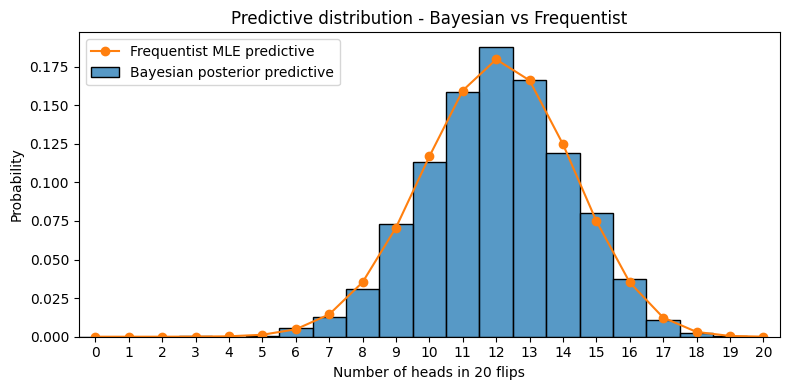

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom

# Draw Binomial(20,p) for each posterior sample p in `samples`
bayes_predictions = binom.rvs(20, samples, random_state=rng)

fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(bayes_predictions, 
            bins = np.arange(-0.5, 20.5, 1),
            stat='probability', 
            label='Bayesian posterior predictive',
            ax=ax)

# Frequentist (plug-in) model - one p value
n = 20
p_hat = mle
k = np.arange(0, n+1)
pmf = binom.pmf(k, n, p_hat) # probability mass function

ax.plot(
    k, pmf,
    'o-', 
    color=sns.color_palette()[1],
    label='Frequentist MLE predictive',
    markersize=6
)

# Plotting parameters
ax.set_xlabel('Number of heads in 20 flips')
ax.set_ylabel('Probability')
ax.set_title('Predictive distribution - Bayesian vs Frequentist')
ax.set_xticks(np.arange(0, 21))
ax.set_xlim(-0.5, 20.5)
ax.legend()
plt.tight_layout()
plt.show()

**Interpretation**

Both methods produce almost the same curve here because the data make the estimate of the coin’s bias extremely precise. The frequentist (plug-in) approach treats the estimate (MLE) as if it were the true parameter, so its predictions come straight from a single binomial model. The Bayesian version mixes over many nearby parameter values, but when those values are tightly clustered, i.e. a narrow posterior, the mixture collapses to something that looks nearly identical to the frequentist approach.

## 2.2. Variance Reduction with Importance Sampling (5 marks)

Many integrals that arise in statistics and machine learning cannot be evaluated analytically, especially in higher dimensions. **Monte Carlo (MC) integration** is a general technique to approximate such integrals by drawing random samples from a distribution and averaging function evaluations. Although MC estimators are unbiased, their variance can be large, meaning we may need many samples to reach a desired accuracy.  

A way to improve efficiency is through **importance sampling (IS)**. Instead of sampling from a fixed distribution (e.g., Gaussian), we choose a proposal distribution $q(X_{train})$ that better matches the regions where the integrand contributes most. By reweighting samples, we can reduce variance while keeping the estimator unbiased. The effectiveness of IS depends critically on choosing $q(X_{train})$ with heavier tails or shapes aligned with the integrand.  

In this exercise, I evaluate a 2D integral and demonstrate how importance sampling can achieve significant variance reduction compared to plain Monte Carlo:  

$$
I = \int_{\mathbb{R}^2} \exp(-\|x\|_1)\,\sin(\|x\|_2)\,dx,
$$  

with the goal of achieving an **absolute error < 0.01**.  

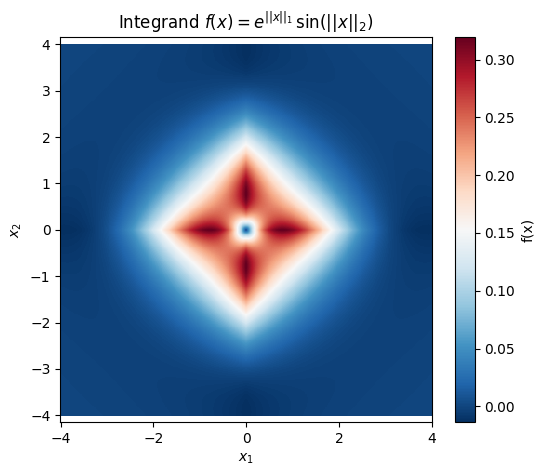

In [5]:
# Visualize the integrand
import numpy as np
import matplotlib.pyplot as plt

def integrand(x):
    l1 = np.sum(np.abs(x), axis=-1)   # L1 norm
    l2 = np.linalg.norm(x, axis=-1)   # L2 norm
    return np.exp(-l1) * np.sin(l2)

# grid
xx, yy = np.meshgrid(np.linspace(-4,4,400), np.linspace(-4,4,400))
pts = np.stack([xx,yy], axis=-1)
zz = integrand(pts)

# plot
plt.figure(figsize=(6,5))
plt.pcolormesh(xx, yy, zz, cmap="RdBu_r", shading="auto")
plt.colorbar(label="f(x)")
plt.title("Integrand $f(x) = e^{||x||_1} \\, \\sin(||x||_2)$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.show()

### Plain Monte Carlo

I estimate $I$ by sampling $x \sim \mathcal{N}(0, I_2)$ and using the plain Monte Carlo estimator
$$
\hat{I} = \frac{1}{N} \sum_{i=1}^N f(x_i), \quad x_i \sim \mathcal{N}(0, I_2).
$$
I also compute the empirical standard error and check how it scales as $N$ increases.

**Plain Monte Carlo estimator + error scaling**

In [6]:
## Estimating I with plain Monte Carlo

from scipy.stats import multivariate_normal
rng = np.random.default_rng(1) # New random seed for different task

N_plain = int(1e4) # Set value of samples to use in plain and IS MC
mean = np.zeros(2)
cov = np.eye(2)
normal_dist = multivariate_normal(mean=mean, cov=cov) # standard multivariate (2D) normal

def estimate_integrand_plain(N): 
    """
    Monte Carlo estimate of E[f(X)], and its estimator variance, using N draws from the 
    2D standard normal.
    """
    samples = normal_dist.rvs(size=N, random_state=rng) # draw N i.i.d. samples
    f_vals = integrand(samples) # evaluate integrand
    estimate = np.mean(f_vals) # MC estimator
    point_variance = np.var(f_vals, ddof=1) # sample variance of f(x)
    estimator_variance = point_variance / N # variance of mean estimator
    return estimate, estimator_variance

estimate_plain, estimator_variance_plain = estimate_integrand_plain(N_plain)
se_plain = np.sqrt(estimator_variance_plain) # standard error of estimator

print(f"Estimate of integral (plain MC) = {estimate_plain:.6f}")
print(f"Standard empirical error = {se_plain:.6f}")

Estimate of integral (plain MC) = 0.177509
Standard empirical error = 0.000810


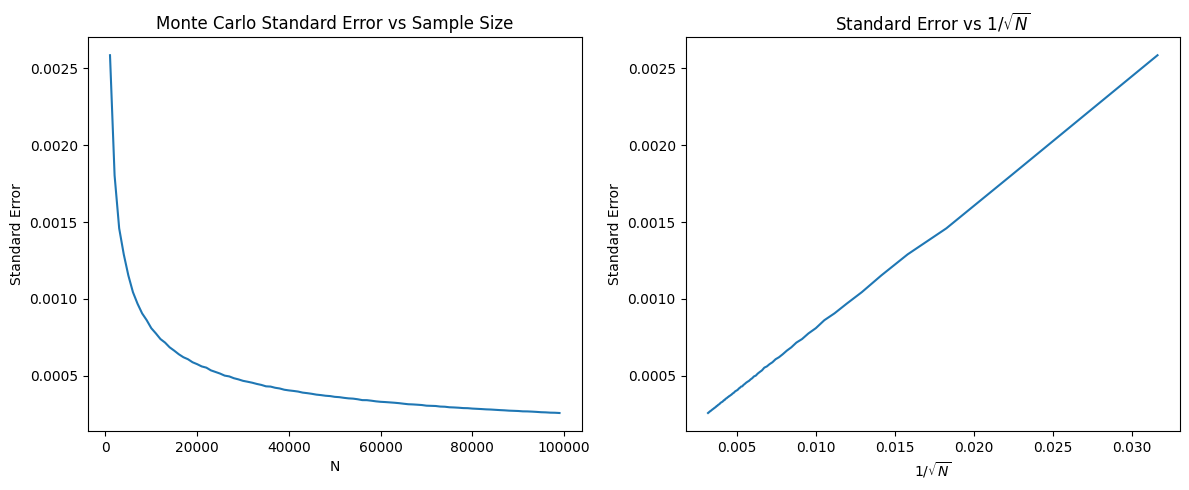

In [7]:
## Verifying that error decreases as N increases

N_vals = np.arange(1000, int(1e5), 1000) # Sample sizes to test
se_vals_plain = np.zeros(len(N_vals))
inv_sqrt_N = 1 / np.sqrt(N_vals)

for i, N_val in enumerate(N_vals):
    _, variance = estimate_integrand_plain(N_val)
    se_vals_plain[i] = np.sqrt(variance) # Store SE

# Plot error decreasing with N
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(N_vals, se_vals_plain)
axes[0].set_title("Monte Carlo Standard Error vs Sample Size")
axes[0].set_xlabel("N")
axes[0].set_ylabel("Standard Error")

# Show linearity of SE with 1/root(N)
axes[1].plot(inv_sqrt_N, se_vals_plain)
axes[1].set_title(r"Standard Error vs $1/\sqrt{N}$")
axes[1].set_xlabel(r"$1 / \sqrt{N}$")
axes[1].set_ylabel("Standard Error")
plt.tight_layout()
plt.show()

### Importance Sampling

To improve efficiency, I design a proposal distribution $q(x)$ and implement an importance sampling estimator. I then compare variance against the plain Monte Carlo estimator for the same number of samples.

I use a Student-t proposal family and tune its parameters (scale and degrees of freedom) via a simple grid search to reduce the estimator’s standard error.

**Importance sampling estimator + proposal tuning**

In [8]:
## Function to estimate I using importance sampling MC

def estimate_integrand_is(N, target_dist, proposal_dist):
    """
    Importance-sampling estimate of E[f(X)] and variance using N proposal draws.
    """
    samples = proposal_dist.rvs(size=N, random_state=rng) # draw from proposal
    f_vals = integrand(samples)
    target_pdf_vals = target_dist.pdf(samples) # target density
    proposal_pdf_vals = proposal_dist.pdf(samples) # proposal density

    # Clip proposal mass away from zero to avoid exploding IS weights when q(x) is tiny
    weights = target_pdf_vals / np.clip(proposal_pdf_vals, a_min=1e-12, a_max=None) # importance weights
    weighted_vals = f_vals * weights

    estimate = np.mean(weighted_vals) # IS estimator
    point_variance = np.var(weighted_vals, ddof=1) # variance of weights*f
    estimator_variance = point_variance / N # variance of estimator
    
    return estimate, estimator_variance

In [9]:
# Grid-search student-t proposal parameters (scale, df) for minimum standard error
# Gives a "well-selected" prior

from scipy.stats import multivariate_t

min_se_is = np.inf
best_scale, best_df = None, None

for scale in np.arange(0.1, 2, 0.05):
    for df in np.arange(1, 100, 2):
        t_dist = multivariate_t(loc=mean, shape=scale*cov, df=df)
        is_estimate, is_var = estimate_integrand_is(N_plain, normal_dist, t_dist)
        is_se = np.sqrt(is_var)

        # Save best params
        if is_se < min_se_is:
            min_se_is, best_var_is, best_est_is, best_scale, best_df = is_se, is_var, is_estimate, scale, df
            t_dist_optimised = multivariate_t(loc=mean, shape=scale*cov, df=df)

print("Student-t poposal distribution:")
print(f"Best scale: {best_scale:.2f}, Best df: {best_df}")
print(f"Estimate: {best_est_is:.6f}, SE: {min_se_is:.6f}")

# Show variance reduction for same N
print(f"Variance ratio (IS/MC): {best_var_is/estimator_variance_plain:.3f}")

Student-t poposal distribution:
Best scale: 0.60, Best df: 89
Estimate: 0.176956, SE: 0.000414
Variance ratio (IS/MC): 0.261


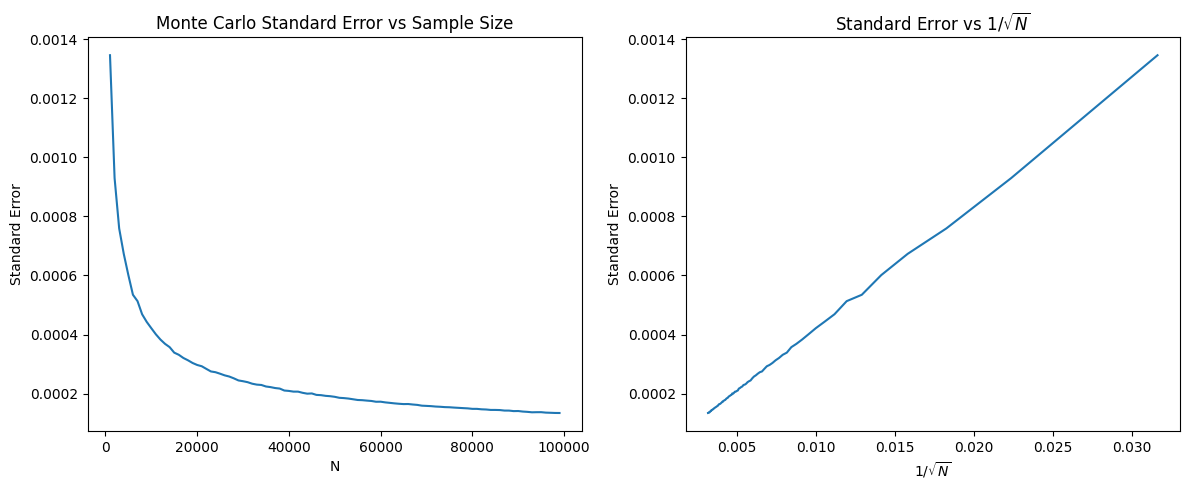

In [10]:
## Verifying that error decreases as N increases

se_vals_is = np.zeros(len(N_vals))

for i, N_val in enumerate(N_vals): # Same range as plain MC plot for comparison
    _, variance = estimate_integrand_is(N_val, normal_dist, t_dist_optimised)
    se_vals_is[i] = np.sqrt(variance)

# Plot error decreasing with N
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(N_vals, se_vals_is)
axes[0].set_title("Monte Carlo Standard Error vs Sample Size")
axes[0].set_xlabel("N")
axes[0].set_ylabel("Standard Error")

# Show linearity of SE with 1/root(N)
axes[1].plot(inv_sqrt_N, se_vals_is)
axes[1].set_title(r"Standard Error vs $1/\sqrt{N}$")
axes[1].set_xlabel(r"$1 / \sqrt{N}$")
axes[1].set_ylabel("Standard Error")
plt.tight_layout()
plt.show()

### RMSE comparison across sample sizes

I compare plain Monte Carlo and importance sampling using RMSE vs. sample size $N$ on a log–log plot. To do this, I compute a high-precision reference estimate and treat it as a baseline for error calculation.

**RMSE vs sample size (log–log)**

In [11]:
# Establish high-precision baseline so RMSE curves have a stable reference
N_ref = int(1e7)
I_ref, _ = estimate_integrand_plain(N_ref)

# Sample sizes and number of independent runs
N_vals = np.logspace(3, 5, num=10, dtype=int)
M = 100 # Average over 100 independent runs per N to smooth Monte Carlo noise

rmse_plain_vals = np.zeros(len(N_vals))
rmse_is_t_vals = np.zeros(len(N_vals))

# Outer loop sweeps sample sizes, inner loops collect estimates then compute RMSE vs reference
for i, N_val in enumerate(N_vals):
    # Plain MC
    I_estimates_plain = np.zeros(M)
    for m in range(M):
        I_est_plain, _ = estimate_integrand_plain(N_val)
        I_estimates_plain[m] = I_est_plain
    rmse_plain_vals[i] = np.sqrt(np.mean((I_estimates_plain - I_ref)**2))

    # Importance Sampling
    I_estimates_is = np.zeros(M)
    for m in range(M):
        I_est_is, _ = estimate_integrand_is(N_val, normal_dist, t_dist_optimised)
        I_estimates_is[m] = I_est_is
    rmse_is_t_vals[i] = np.sqrt(np.mean((I_estimates_is - I_ref)**2))

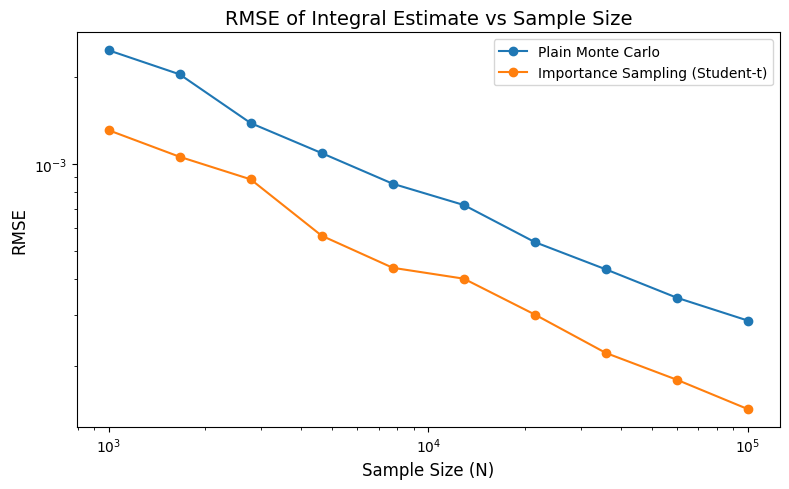

In [12]:
# Plot RMSE vs. N (log–log)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(N_vals, rmse_plain_vals, 'o-', label='Plain Monte Carlo', markersize=6)
ax.plot(N_vals, rmse_is_t_vals, 'o-', label='Importance Sampling (Student-t)', markersize=6)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Sample Size (N)', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('RMSE of Integral Estimate vs Sample Size', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()

In [13]:
# Show absolute error < 0.01 for both methods
abs_err_plain = abs(estimate_plain - I_ref)
abs_err_is = abs(best_est_is - I_ref)
print(f"|I_plain - I_ref| = {abs_err_plain:.4f}")
print(f"|I_IS - I_ref| = {abs_err_is:.4f}")


|I_plain - I_ref| = 0.0007
|I_IS - I_ref| = 0.0001


**Justification**

I selected the Student-t family because its tail behaviour can be adjusted to match the decay of the integrand. A proposal that decays too quickly risks missing regions that still contribute, leading to unstable importance weights. Student-t avoids this by allowing controlled tail-heaviness through the degrees of freedom.

The optimisation then identified a high df as the most effective choice, approaching the Gaussian limit. This shows that, once the tail-width was allowed to adapt, the best match to the integrand’s decay happened to be the light-tailed case. The Student-t family provided the flexibility to reach that outcome without assuming it in advance. In practice, the optimised proposal aligned well with the integrand’s decay, stabilised the weights, and reduced the variance by roughly a factor of three for the same sample size.

## 2.3. Mean-Field Variational Inference for Bayesian Logistic Regression

In this exercise, I implement **Bayesian logistic regression** and approximate its posterior distribution using **mean-field variational inference (VI)**. I then compare VI with a **Hamiltonian Monte Carlo (HMC)** benchmark to highlight the trade-offs between computational efficiency and posterior accuracy. The dataset `log_reg_data.csv` contains predictors `x1, x2, …` and a binary label `y`.

### 2.3.1. Background & Motivation

- **Bayesian logistic regression** models uncertainty in the regression weights $w$, allowing us to quantify predictive uncertainty rather than relying only on a point estimate (as in standard logistic regression). The prior is chosen as a Gaussian:  
  $$
  w \sim \mathcal{N}(0, 10I).
  $$  

- **Variational Inference (VI)** approximates the true posterior $p(w \mid D)$ by a simpler distribution. Here, we use a **mean-field Gaussian**:  
  $$
  q_\phi(w) = \mathcal{N}(w \mid \mu, \mathrm{diag}(\sigma^2)),
  $$  
  where the parameters $\phi = (\mu, \sigma)$ are optimised to make $q_\phi$ close to the true posterior.  

- Optimisation is done via the **Evidence Lower Bound (ELBO)**:  
  $$
  \mathcal{L}(\phi) = \mathbb{E}_{q_\phi}[ \log p(D \mid w) ] - \mathrm{KL}(q_\phi \,\|\, p(w)),
  $$  
  which we estimate stochastically using the **reparameterisation trick**:  
  $$
  w = \mu + \sigma \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I).
  $$  

- **Hamiltonian Monte Carlo (HMC)** provides a high-fidelity posterior approximation by simulating from the exact Bayesian posterior using gradient information. It is computationally more expensive but is often treated as the “gold standard” for comparison.  

### Variational inference (mean-field Gaussian)

In [14]:
import numpy as np
import pandas as pd
from autograd import grad
import autograd.numpy as anp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

**VI implementation + ELBO training curve**

In [15]:
# Load data, check shape and nulls
log_reg_df = pd.read_csv('datasets_part_1/log_reg_data.csv')
print(f"Shape: {log_reg_df.shape}")
print(f"Null counts:\n{log_reg_df.isna().sum().sum()}")

Shape: (10000, 21)
Null counts:
0


In [16]:
# Split columns
X = log_reg_df.drop(columns=['y']).values
y = log_reg_df['y'].values

# Add bias column
bias = np.ones((X.shape[0], 1))
X = np.hstack([bias, X])
D = X.shape[1]

# Train test split for 1.3.C
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [17]:
from autograd.scipy.special import expit

# Prior (Multivariate Gaussian Distribution)
mu_prior = np.zeros(D)  # Prior mean for mu
cov_scale = 10.0
cov_prior = cov_scale*np.eye(D)  # Prior covariance matrix

# Variational Parameters (Posterior Approximation)
mu_q = np.zeros(D)  # Initial mean estimate for variational posterior
log_cov_q = np.log(np.ones(D) * 0.1)  # Initial log of covariance matrix

# New task, new random seed
vi_seed = 1234
vi_rng = np.random.default_rng(vi_seed)

# Define elbo function
def elbo(mu_q, log_cov_q, epsilon, rng, num_kl_samples=400):
    """
    Stochastic ELBO for Bayesian logistic regression with diagonal Gaussian q(w).
    """
    # Reparameterisation trick
    # anp for autograd
    sigma_q = anp.exp(0.5*log_cov_q)
    w = mu_q + sigma_q * epsilon
    logits = anp.dot(X_train, w)
    
    # Log likelihood
    # Keep probabilities away from 0/1 to avoid log(0) during ELBO evaluation
    prob_clip = 1e-12
    probs = anp.clip(expit(logits), prob_clip, 1 - prob_clip)
    log_likelihood = anp.sum(
        y_train * anp.log(probs) 
        + (1 - y_train) * anp.log(1 - probs)
        )

    # Estimate KL divergence with Monte Carlo (variance dependent on `num_kl_samples`)
    sigma_prior = anp.sqrt(anp.diag(cov_prior))

    # Draw samples from q(w)
    eps_samples = rng.multivariate_normal(np.zeros(D), np.eye(D), size=num_kl_samples)
    w_samples = mu_q + eps_samples * sigma_q

    # log density helper function
    def log_diag_gaussian(x, mu, sigma):
        return -0.5 * anp.sum(
            ((x - mu)**2) / (sigma**2)
            + 2 * anp.log(sigma)
            + anp.log(2 * anp.pi),
            axis=1
        )
    
    log_q = log_diag_gaussian(w_samples, mu_q, sigma_q)
    log_p = log_diag_gaussian(w_samples, mu_prior, sigma_prior)

    kl_mc = anp.mean(log_q - log_p)  # Monte Carlo KL estimate

    return log_likelihood - kl_mc

log_sigma_q_clip_range = 20.0  # Prevents overflow (e^20 is still a large std deviation but avoids infinity)

# Define objective function
def objective(params, _):
    """
    Negative ELBO objective for optimisation, because Adam minimises functions.
    """
    mu_q, log_cov_q = params
    log_cov_q = anp.clip(log_cov_q, -log_sigma_q_clip_range, log_sigma_q_clip_range) # stabilise covariance
    
    # One reparameterisation sample per objective evaluation
    epsilon = vi_rng.multivariate_normal(np.zeros(D), np.eye(D))

    return -elbo(mu_q, log_cov_q, epsilon, vi_rng)

In [18]:
from autograd.misc.optimizers import adam

# Optimization Settings
learning_rate = 0.01 # Step size for Adam updates - fairly high as Adam is adaptive and stable
num_iterations = 4000
elbo_values = []  # Store ELBO values for monitoring convergence

# Track ELBO values during optimisation
def track_elbo(params, *_):
    """
    Callback used during optimisation to record the current ELBO value.
    """
    current_elbo = -objective(params, _)
    elbo_values.append(current_elbo)

# Run Adam optimisation on variational parameters
init_params = (mu_q, log_cov_q)
optimized_params = adam(
        grad(objective),
        init_params,
        step_size=learning_rate,
        num_iters=num_iterations,
        callback=track_elbo)

# Unpack final values
mu_q_vi, log_cov_q_vi = optimized_params

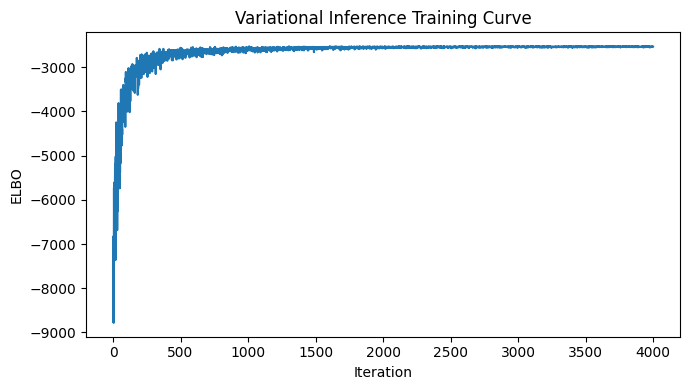

In [19]:
# Plot training curve to show convergence
plt.figure(figsize=(7, 4))
plt.plot(elbo_values, label='ELBO')
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.title(f'Variational Inference Training Curve')
plt.tight_layout()
plt.show()

### HMC benchmark (NumPyro)

Next I use JAX + NumPyro to run multi-chain HMC (NUTS) for Bayesian logistic regression, then check convergence diagnostics (including $\hat{R}$).

In [20]:
import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import summary

/Users/archie/Documents/MSc_modules/semester_1/reasoning_under_uncertainty/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**HMC sampling + convergence diagnostics**

In [21]:
from jax.scipy.special import expit

# Data setup (need as jax numpy arrays)
X_train_jax = jnp.array(X_train)
y_train_jax = jnp.array(y_train)

# Logistic regression model
def logistic_regression_model(X, y=None):
    """
    Bayesian logistic regression with a Gaussian prior and Bernoulli likelihood.
    """
    # Prior
    w = numpyro.sample("w", dist.Normal(0, jnp.sqrt(10)).expand([X.shape[1]]))
    # Likelihood
    probs = expit(jnp.dot(X, w))
    numpyro.sample("y", dist.Bernoulli(probs=probs), obs=y)

# HMC setup
num_chains = 4 # parallel chains
num_warmup = 1000
num_samples = 2000  # produces >=1000 effective samples after warmup
rng_key = random.PRNGKey(0) # seed for reproducibility

kernel = NUTS(logistic_regression_model) # No U-Turn Sampler (adaptive HMC)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

# Run HMC sampling
mcmc.run(rng_key, X=X_train_jax, y=y_train_jax)
mcmc.print_summary()

# Get posterior samples for w
hmc_posterior_samples = mcmc.get_samples()

/var/folders/dm/0q6htkbd05x421zn2qxfqhkc0000gp/T/ipykernel_5284/522225682.py:25: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1308.84it/s, 7 steps of size 5.84e-01. acc. prob=0.85]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      w[0]     -0.01      0.04     -0.01     -0.07      0.05  18123.36      1.00
      w[1]      0.12      0.04      0.12      0.06      0.18  18456.93      1.00
      w[2]     -1.40      0.05     -1.40     -1.47     -1.32   6195.69      1.00
      w[3]      0.15      0.04      0.15      0.10      0.21  20743.97      1.00
      w[4]     -1.32      0.05     -1.32     -1.40     -1.25   6031.00      1.00
      w[5]     -0.34      0.04     -0.34     -0.41     -0.28  16470.61      1.00
      w[6]     -1.52      0.05     -1.52     -1.61     -1.45   6114.81      1.00
      w[7]      0.67      0.04      0.67      0.61      0.74   9615.57      1.00
      w[8]      0.62      0.04      0.62      0.56      0.69  10256.67      1.00
      w[9]     -0.26      0.04     -0.26     -0.32     -0.20  16197.98      1.00
     w[10]      0.35      0.04      0.35      0.29      0.41  13881.79      1.00
     w[11]      0.92      0

In [22]:
# Report convergence diagnostics
summary_dict = summary(hmc_posterior_samples)
rhat_values = [v["r_hat"] for v in summary_dict.values()]
max_rhat = max(rhat_values)
print(f"Max R-hat: {max_rhat:.3f}") # confirm <= 1.05

Max R-hat: 1.010


### Posterior comparison (VI vs HMC)

I approximate $\mathrm{KL}(q_\phi \parallel p(w \mid D))$ by fitting a Gaussian to HMC samples and evaluating the KL with Monte Carlo samples from the VI distribution. I also compare predictive performance via test-set log-loss under both VI and HMC.

In [23]:
import numpy as np
from sklearn.metrics import log_loss
from scipy.special import expit

**KL estimate + test-set log-loss comparison**

In [24]:
# Extract posterior draws from HMC
reference_posterior = hmc_posterior_samples["w"]  # shape (num_samples, D)

# Fit Gaussian approximation to HMC samples
mean_hmc = np.mean(reference_posterior, axis=0)
cov_hmc = np.cov(reference_posterior, rowvar=False)

# Match VI sample count to HMC sample count
n_samples = reference_posterior.shape[0]
kl_seed = 2025
kl_rng = np.random.default_rng(kl_seed)

# Reparameterisation trick
eps = kl_rng.standard_normal((n_samples, mu_q_vi.size)) # N(0, I)
w_vi = mu_q_vi + np.exp(0.5 * log_cov_q_vi) * eps # VI posterior samples

# Compute log q_vi for each sample (diagonal Gaussian)
def diag_gaussian_logpdf(x, mean, log_var):
    """
    Log-density of a diagonal Gaussian.
    """
    return -0.5 * np.sum(
        (x - mean) ** 2 / np.exp(log_var)
        + log_var
        + np.log(2 * np.pi),
        axis=1
    )

# log q(w) under VI posterior
log_q_vi = diag_gaussian_logpdf(w_vi, mu_q_vi, log_cov_q_vi)

# Compute log p(w) under Gaussian approximation to HMC posterior
mv_hmc = multivariate_normal(mean=mean_hmc, cov=cov_hmc)
log_p_hmc = mv_hmc.logpdf(w_vi)

# Monte Carlo estimate of KL divergence
kl = np.mean(log_q_vi - log_p_hmc)

print(f"KL Divergence (VI || HMC): {kl:.6f}")

KL Divergence (VI || HMC): 2.229465


In [25]:
# VI predictive mean (Monte Carlo)
y_pred_vi = expit(X_test @ w_vi.T).mean(axis=1)

# HMC predictive mean
y_pred_hmc = expit(X_test @ reference_posterior.T).mean(axis=1)

log_loss_vi = log_loss(y_test, y_pred_vi)
log_loss_hmc = log_loss(y_test, y_pred_hmc)

# Plot table
print("Method                  |  Log-Loss")
print("------------------------|----------")
print(f"Variational Inference   |  {log_loss_vi:.6f}")
print(f"HMC                     |  {log_loss_hmc:.6f}")

Method                  |  Log-Loss
------------------------|----------
Variational Inference   |  0.309858
HMC                     |  0.310617


# 3. Gaussian processes and Bayesian Optimisation

Here I use Gaussian processes for Bayesian optimisation of the hyperparameters of a machine learning model. The dataset is taken from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). The task is to predict electrical energy output from a combined cycle power plant; the dataset description is [here](https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant).

## 3.1. Bayesian optimisation of Elastic net hyperparameters

I use Thompson Sampling (TS) to optimise an Elastic Net regressor over the energy output dataset. The two hyperparameters are $\alpha>0$ and $0\le\rho\le1$. The function I aim to minimise is validation RMSE:

$$
\text{RMSE}(\alpha, \rho) = \sqrt{\text{MSE}(\mathbf{y}_\text{val}, f(\mathbf{x}_{\text{val}}, \mathcal{D}_\text{train}, \alpha, \rho))}.
$$

I first load the dataset and split it into training, validation, and test sets.

In [26]:
import urllib.request
doq = "https://archive.ics.uci.edu/static/public/294/combined+cycle+power+plant.zip"
pat_sav = "./combined+cycle+power+plant.zip"
urllib.request.urlretrieve(doq, pat_sav)

('./combined+cycle+power+plant.zip', <http.client.HTTPMessage at 0x30fcda350>)

In [27]:
import zipfile
zip = zipfile.ZipFile('./combined+cycle+power+plant.zip', 'r')
for name in zip.namelist():
    zip.extract(name, '.')

In [28]:
import pandas as pd
import numpy as np
energy_output = pd.read_excel('./CCPP/Folds5x2_pp.xlsx','Sheet1')

The dataset has 9568 observations. I use a subset of $N_m$ and then split it into training/validation/test partitions (80/10/10).

In [29]:
N_m = 9000
ndata, ncols = np.shape(energy_output)
np.random.seed(11230)                 # Make sure you use the last five digits of your student UCard as your seed
index = np.random.permutation(ndata)  # We permute the indexes  
data_tot_red = energy_output.iloc[index[0:N_m], :].copy() # Select N_m points
Ne = np.int64(np.round(0.8*N_m))    # We compute N, the number of training instances
Neval = np.int64(np.round(0.1*N_m)) # We compute Nval, the number of validation instances   
Netest = N_m - Ne - Neval              # We compute Ntest, the number of test instances
index = np.random.permutation(N_m)  # We permute the indexes  
data_training = data_tot_red.iloc[index[0:Ne], :].copy() # Select the training data
data_val = data_tot_red.iloc[index[Ne:Ne+Neval], :].copy() # Select the validation data
data_test = data_tot_red.iloc[index[Ne+Neval:N_m], :].copy() # Select the test data

In [30]:
Xe_train = np.concatenate((np.ones((Ne,1)), (data_training.iloc[:, 0:4]).values), axis=1) 
ye_train = np.reshape((data_training.iloc[:, 4]).values, (Ne,1))
Xe_val = np.concatenate((np.ones((Neval,1)), (data_val.iloc[:, 0:4]).values), axis=1) 
ye_val = np.reshape((data_val.iloc[:, 4]).values, (Neval,1))
Xe_test = np.concatenate((np.ones((Netest,1)), (data_test.iloc[:, 0:4]).values), axis=1) 
ye_test = np.reshape((data_test.iloc[:, 4]).values, (Netest,1))

### 3.1.1. Initial space-filling design

I begin by collecting a small initial set of evaluations of the objective. I use $n_0 = 5$ initial points, producing initial observations `X0train` and `y0train`.

**Initial design + objective evaluations**

In [31]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

# Scale input features
scaler_X = StandardScaler()
Xe_train_scaled = scaler_X.fit_transform(Xe_train)
Xe_test_scaled = scaler_X.transform(Xe_test)
Xe_val_scaled = scaler_X.transform(Xe_val)

# Number of initial samples
n0 = 5

# Sample alpha logarithmically and rho uniformly
alpha_vals = 10 ** np.random.uniform(-4, 0, size=n0)
rho_vals = np.random.uniform(0.0, 1.0, size=n0)

# Stack to form initial design matrix
X0train = np.vstack((alpha_vals, rho_vals)).T

# Define objective function (RMSE)
def gp_rmse(y_pred, y_true):
    """
    Compute RMSE between predictions and true values.
    """
    y_pred = np.asarray(y_pred).ravel()
    y_true = np.asarray(y_true).ravel()
    return np.sqrt(((y_pred - y_true) ** 2).mean())

# Container for initial RMSE values
rmse_vals = np.zeros(n0)

# Evaluate RMSE for each initial (alpha, rho) pair
for i in range(n0):
    base_model = ElasticNet(alpha=alpha_vals[i], l1_ratio=rho_vals[i], random_state=42)
    base_model.fit(Xe_train_scaled, ye_train)

    y_pred = base_model.predict(Xe_val_scaled) # Predict on validation set
    
    rmse_vals[i] = gp_rmse(y_pred, ye_val) # Compute and store RMSE

# Initial training RMSE values
y0train = rmse_vals

### 3.1.2. Sequential decision loop (Thompson sampling)

I run a Bayesian optimisation loop with a budget of 20 function evaluations. Each iteration:

1. Fits a GP surrogate model to all observed data.

2. Uses Thompson sampling over a grid to select the next candidate point.

3. Evaluates validation RMSE at that point and appends the new observation.

At the end, I extract the best observed $(\alpha, \rho)$ as $(\alpha_*, \rho_*)$.

**GP surrogate + Thompson sampling loop**

In [32]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def thompson_sampling(Xtrain, ytrain, Xgrid):
    """
    Thompson sampling step using an exact GP posterior over Xgrid.
    """
    # Define RBF kernel
    s_f = 1.0 # Initial values, will be optimised by GPRegressor
    l_s = 0.5
    kernel = s_f * RBF(length_scale=l_s,
                        length_scale_bounds=(1e-2, 5)
                        )
    
    # Fit GP on training data
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=True,
        n_restarts_optimizer=3, # optimise s_f and l_s
        # Add jitter for numerical stability
        alpha=1e-4,
        random_state=11230
    )
    gpr.fit(Xtrain, ytrain) # fit GP on observed evaluations

    # GP posterior mean and covariance on grid
    mu, cov = gpr.predict(Xgrid, return_cov=True)

    # Draw one sample from GP posterior
    f_sample = np.random.multivariate_normal(mean=mu, cov=cov)

    # Pick minimizer of the sampled function
    x_next = Xgrid[np.argmin(f_sample)]

    return x_next

In [33]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ElasticNet convergence warnings
warnings.filterwarnings(
    "ignore",
    category=ConvergenceWarning
)

# Parameter grid to search over/evaluate in BayesOpt/Thompson sampling
eps = 1e-4 # Min value for rho, 0 causes convergence errors
n_points = 30  # resolution per dimension

# Again sample alpha logarithmically and rho uniformly
alpha_vals = np.logspace(-4, 0, n_points)
rho_vals = np.linspace(eps, 1.0, n_points)

X1, X2 = np.meshgrid(alpha_vals, rho_vals, indexing="xy") # Create 2D grid
Xgrid = np.column_stack([X1.ravel(), X2.ravel()]) # Flatten to (n_points^2, 2)

# Number of Thompson-sampling steps
N_evals_bayesopt = 20

def optimisation_loop():
    """
    Sequential Thompson-sampling Bayesian optimisation of (alpha, rho).
    """
    # Start from initial design
    Xtrain, ytrain = X0train.copy(), y0train.copy()

    for _ in range(N_evals_bayesopt):
        # Thompson sampling proposes the next hyperparameter pair
        x_next = thompson_sampling(Xtrain, ytrain, Xgrid)

        # Train elastic net with suggested hyperparameters
        model = ElasticNet(alpha=x_next[0], l1_ratio=x_next[1], random_state=42)
        model.fit(Xe_train_scaled, ye_train)

        # Validation RMSE acts as objective value
        y_pred = model.predict(Xe_val_scaled)
        y_next = gp_rmse(y_pred, ye_val)

        # Append new observation to GP training data
        Xtrain = np.vstack((Xtrain, x_next)) 
        ytrain = np.append(ytrain, y_next)

    return Xtrain, ytrain

# Run sequential Bayesian optimisation
Xtrain_final, ytrain_final = optimisation_loop()

# Extract best-performing parameters
min_rmse_arg = np.argmin(ytrain_final)
alpha_star = Xtrain_final[min_rmse_arg,0]
rho_star = Xtrain_final[min_rmse_arg,1]

print(f"Alpha = {alpha_star:.6f}")
print(f"Rho = {rho_star:.6f}")
print(f"Min RMSE = {min(ytrain_final):.6f}")

Alpha = 0.041753
Rho = 0.793124
Min RMSE = 4.442766


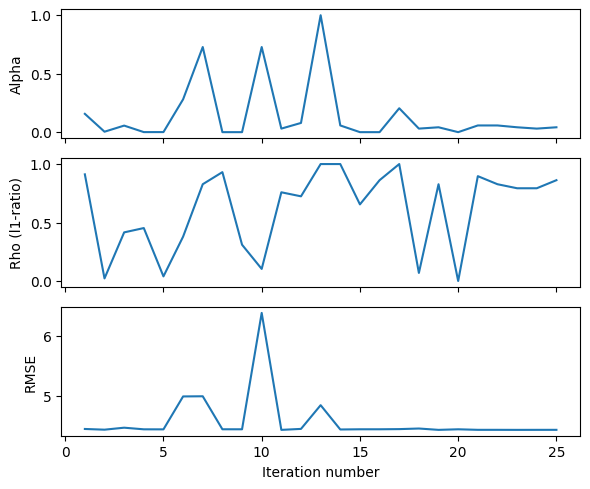

In [34]:
# Extract sequences
alphas = Xtrain_final[:, 0]
rhos = Xtrain_final[:, 1]
rmses = ytrain_final
iters = np.arange(len(rmses))

# Plot
fig, axes = plt.subplots(3, 1, figsize=(6, 5), sharex=True)

axes[0].plot(iters+1, alphas)
axes[0].set_ylabel("Alpha")

axes[1].plot(iters+1, rhos)
axes[1].set_ylabel("Rho (l1-ratio)")

axes[2].plot(iters+1, rmses)
axes[2].set_ylabel("RMSE")
axes[2].set_xlabel("Iteration number")

plt.tight_layout()
plt.show()

### 3.1.3. Test-set performance + baseline comparison

I evaluate the Elastic Net model on the test set using the hyperparameters found by Thompson-sampling Bayesian optimisation. I then compare against a straightforward alternative baseline: grid search over $(\alpha, \rho)$.

**Bayesian optimisation: test RMSE**

In [35]:
# Train on optimal parameters
best_model = ElasticNet(alpha=alpha_star, l1_ratio=rho_star, random_state=42)
best_model.fit(Xe_train_scaled, ye_train)

# RMSE on test set
y_pred = best_model.predict(Xe_test_scaled)
rmse_bayes_opt = gp_rmse(y_pred, ye_test)

**Grid search baseline: test RMSE**

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

n_points = 50  # resolution per dimension
alpha_vals = np.logspace(-4, -1, n_points)
rho_vals = np.linspace(eps, 1, n_points)

param_grid = {"alpha": alpha_vals, "l1_ratio": rho_vals}

# Create RMSE scorer (lower is better)
rmse_scorer = make_scorer(lambda y_pred, y_true: gp_rmse(y_pred, y_true), greater_is_better=False)

grid = GridSearchCV(
    ElasticNet(random_state=42),
    param_grid,
    scoring=rmse_scorer,
    cv=3,
    n_jobs=-1
)

# Perform gridsearch
grid.fit(Xe_train_scaled, ye_train)

# RMSE on test set
best_model_gs = grid.best_estimator_
y_pred_gs = best_model_gs.predict(Xe_test_scaled)
rmse_gs = gp_rmse(y_pred_gs, ye_test)

# Optimal parameters found
alpha_gs = grid.best_params_["alpha"]
rho_gs = grid.best_params_["l1_ratio"]

In [37]:
# Print comparison
print("GridSearchCV best params:")
print(f"Alpha: {alpha_gs:.6f}")
print(f"Rho: {rho_gs:.6f}")
print(f"GridSearchCV RMSE: {rmse_gs:.6f}")

print("\nBayesianOpt best params:")
print(f"Alpha: {alpha_star:.6f}")
print(f"Rho: {rho_star:.6f}")
print(f"BayesianOpt RMSE: {rmse_bayes_opt:.6f}")

GridSearchCV best params:
Alpha: 0.000625
Rho: 0.755127
GridSearchCV RMSE: 4.676898

BayesianOpt best params:
Alpha: 0.041753
Rho: 0.793124
BayesianOpt RMSE: 4.668731


**Findings**
- *Finding 1.* Bayesian optimisation and grid search find differing optimal hyperparameter pairs yet yield almost identical test RMSE, indicating a flat optimum region of the objective function.
- *Finding 2.* The Bayesian optimisation drove alpha towards zero but keeps exploring rho values with unchanging RMSE, showing regularisation strength dominates more than L1-L2 mix for predictive performance.